# "Filtrado" espacial

En este cuaderno abordaremos el filtrado espacial, o siendo más especifico el "marcado espacial". Ya en los métodos de corrección de clutter vistos se observa que hay pequeños datos que pierden su valor y presentan pequeñas discontinuidades respecto de la trama principal. También hemos visto que existen pequeños elementos remanentes luego de la remoción de clutter. Ambos atentan con el patrón general observado y son poco probables pues tienen una pequeña área de una textura muy diferente al campo en el que se encuentran. Aquí veremos como tratar con ambas circunstancias.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import warnings 
from scipy import ndimage
import utilidades as util

warnings.filterwarnings('ignore')

Antes de ello es necesario volver a recalcar que el formato original de los datos corresponde a una cuadricula polar por lo que a medida que avanzamos a lo largo del eje radial, el área abarcada por cada dato también lo hace. Esto ocasiona que se deban aplicar los procedimientos típicos de vecindad con cierta reserva. 

Una solución a dicho problema podría ser la transformación a coordenadas cartesianas y ahí aplicar sin problemas el filtrado típico de vecindad. Esto es posible, sin embargo probablemente disemine la cantidad de celdas afectadas por los efectos así como su auténtico valor dado que se realizarán interpolaciones para ello. Aquí se abordará el problema desde la grilla polar, pero los procedimientos descritos son completamente aplicables a grillas cartesianas(tal vez con algunos pequeños ajustes).

Hasta ahora hemos hablado del efecto de la resolución variable, pero ¿qué tan importante es en realidad dicho efecto?

Para ello calcularemos el área en metros cuadrados a lo largo del eje radial. El eje azimutal no se toma en cuenta pues los datos tienen la misma resolución para un mismo valor de distancia radial.

In [3]:
azi, r = util.ejes()
area_vector = np.pi*((r+0.1)**2-r**2)/(2*180)
area_vector = area_vector * 1000**2

Fijémonos en la proporción entre el primer y último elemento.

In [4]:
area_vector[-1]/area_vector[0]

1998.999999999796

La proporción revela que el área resulta 1999 veces! Ello obliga a que un enfoque de vecindad muy grande sea completamente inaplicable. Pero, ¿que hay de las vecindades locales? 
Para ello veremos la proporción entre diversos elementos cercanos ...

In [5]:
area_vector[1]/area_vector[0]

3.0000000000000013

In [6]:
area_vector[2]/area_vector[1]

1.6666666666666663

In [7]:
area_vector[3]/area_vector[2]

1.4000000000000004

In [8]:
area_vector[-1]/area_vector[-2]

1.0010015022533107

Las proporciones calculadas corresponden al vecino más cercano de cualquier vecindad, pero si está fuese más grande el efecto es mucho mayor.

In [9]:
area_vector[3]/area_vector[0]

7.0000000000000036

In [10]:
area_vector[6]/area_vector[1]

4.33333333333333

In [11]:
area_vector[9]/area_vector[2]

3.7999999999999985

De cualquier modo este efecto se atenúa para distancias grandes para las cuales no existirá gran diferencia entre las áreas. 

Ya con la resolución variable en cuenta, mostraremos diferentes enfoques para solucionar el problema que habiamos presentado. Como primera alternativa usaremos el concepto de vecindad para determinar si se realiza o no el filtrado. En segunda instancia, se verá la segmentación y etiquetado de zonas así como su selección en función de su tamaño real y aparente. Por último se mostrarán las operaciones morfológicas básicas como alternativa. 

**Nota:** La mayoría de conceptos del párrafo anterior corresponden al Procesamiento Digital de Imágenes, por ello se usarán los conceptos de píxel en referencia al dato individual dentro de la grilla polar. En ese sentido nuestros datos corresponden a una "imagen" de un solo canal(imagen en escala de grises).

### Marcado en base a vecindad

La vecindad de un píxel esta definida por una submatriz de tamaño KxL, con K y L impares pequeños, en general matriz centrosimétrica , contenida en la matriz imagen, la cual esta formada por un número finito de píxeles vecinos o no del píxel de referencia. 

**Nota:** Los valores K y L deberán ser impares pues estarán centradas en un píxel y en general simétricas para garantizar la propiedad reflexiva en las vecindades, de lo contrario podría pasar que que un píxel A sea vecino de otro B, pero B no sea vecino de A. 

<img src="Vecindad.png">
Pablo Roncagliolo (2008) ELO – 328 Procesamiento digital de imágenes. Curso impartido en la Universidad Técnica Federico Santa María. Chile. Material y diapositivas disponibles en http://www2.elo.utfsm.cl/~elo328/pdf1dpp

El filtrado en base a vecindades, llamado propiamente filtrado convolucional, se basa en escoger un kernel(matriz de factores del mismo tamaño que la vecindad) que permita extraer alguna característica de la vecindad local. Existen diversos kernels ya probados para los procedimientos éstandar. 

Definimos uno de los kernel más usados para identificar píxeles sueltos.

In [12]:
mask = -np.ones(shape=(3,3))
mask[1,1] = 8
mask

array([[-1., -1., -1.],
       [-1.,  8., -1.],
       [-1., -1., -1.]])

¿Cómo es que estos factores nos ayudarán a identificar los píxeles sueltos?

Pensemos un momento en la imagen binarizada, y dentro de ella un elemento suelto es decir un cero rodeado de unos o viceversa.

<img src="Elementos_sueltos.png">

¿Qué sucede cuando usamos el kernel sobre estas submatrices? *Spoiler:* Ambas proporcionan los valores -8 y 8 respectivamente. Si hallamos el valor absoluto del resultado tendremos una excelente resultado comparandolo con nuestro umbral(threshold) de 8.  

Para mostrar como se usa este método necesitaremos llamar algunos datos de ejemplo, a los que ya estamos acostumbrados.

In [13]:
ruta = 'C:\Python37\Clutter'
clutterdata = util.dataclass(ruta)
Matriz = util.matriz3d(clutterdata)
azi, r = util.ejes()

Clutter_max = np.max(Matriz, axis=2)
selem = np.ones(shape=(3,3))
local_max = util.maximum(Clutter_max, selem)
Cadj = 1
Cluttermap = local_max + Cadj

datos, titles = util.testeo(explore=False)
application = [util.mitigation(dato, Cluttermap, mask=True) for dato in datos]

Mostramos los datos iniciales: 

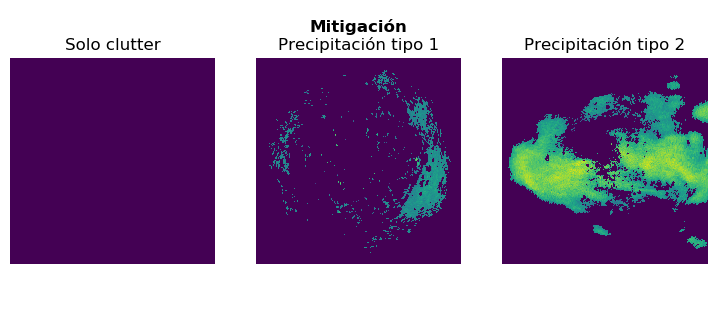

In [14]:
util.testeo_results(cluttermaps=None, results=application, rmax=15, title2='Mitigación')

Para mostrar el procedimiento el primer paso será binarizar la imagen. Esto exige un umbral para el cual los valores superiores serán etiquetados con `1` o `True`, mientras que los menores serán etiquetados con `0` o `False`.

In [15]:
def binary(img, thr=-31.5):
    return (img > thr).astype(int)

In [16]:
binarydata = [binary(result) for result in application]

Vemos los resultados del binarizado.

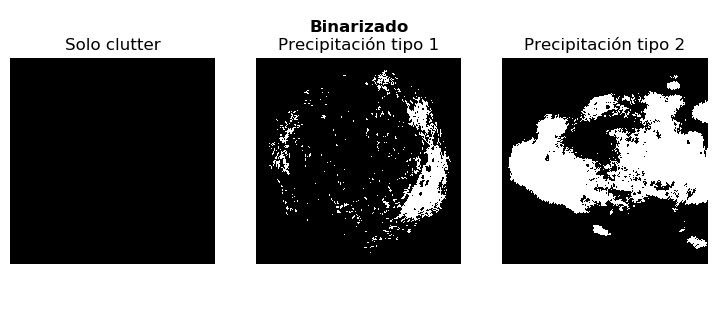

In [17]:
util.testeo_results(cluttermaps=None, results=binarydata, rmax=15, title2='Binarizado', cmap=plt.cm.gray)

Aplicamos el filtrado en base a la vecindad. Para ello aprovecharemos la función `correlate` del módulo **`scipy`**.

In [18]:
fconv =[abs(ndimage.correlate(binimg, mask)) for binimg in binarydata]

Mostramos los resultados:

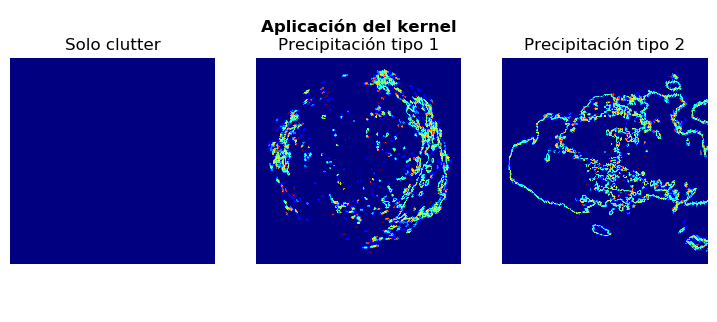

In [19]:
util.testeo_results(cluttermaps=None, results=fconv, rmax=15, title2='Aplicación del kernel', cmap=plt.cm.jet)

Aplicamos el umbral para los datos.

In [20]:
binaf = [fdata >=8 for fdata in fconv]

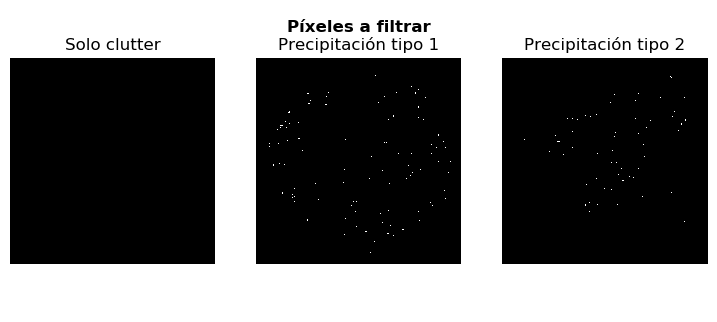

In [21]:
util.testeo_results(cluttermaps=None, results=binaf, rmax=15, title2='Píxeles a filtrar', cmap=plt.cm.gray)

Ya con los valores para filtrado marcados, podemos realizar algún procedimiento para su reemplazo, ya sea una interpolación o regresarlos a sus valores originales.

El tamaño de la vecindad así como del kernel asociado puede usarse para filtrar elementos de tamaños más grandes o de formas diferentes, o incluso para ajustar la severidad del filtrado. Fijese por ejemplo en el siguiente kernel de umbral `24`.

In [22]:
mask2 = - np.ones(shape=(5,5))
mask2[2,2] = 24
mask2

array([[-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., 24., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.]])

Dicho kernel hace lo mismo que el anterior, filtrará elementos individuales; pero a diferencia de su predecesor la condición es mucho más restrictiva, pues solo filtrará elementos sueltos dentro de una matriz más grande. Así, con esta nuevo kernel se puede hacer un filtrado más "hard". Pero también podemos filtrar elementos más grandes usando diferentes configuraciones. Antes de hacer algo de ese tipo analice también que sucede en los bordes de tormenta. 

Sin embargo, esto requiere cierto conocimiento del tamaño de los elementos que queremos marcar para el filtrado, y de manera relativa(no en tamaño real sino en tamaño según el número de elementos presentes en la grilla). Por ello, su uso está dirigido a ingenieros que conozcan del tema en lugar de los usuarios del radar. 

Es momento de pasar al segundo filtrado. 

### Marcado en base a segmentación y etiquetado  

La segmentación que realizaremos esta basada en la conectividad de elementos. Para establecer la conectividad de dos píxeles es necesario evaluar si comparten valores parecidos y si se encuentran conectados.

<img src="Conectividad.png">
Pablo Roncagliolo (2008) ELO – 328 Procesamiento digital de imágenes. Curso impartido en la Universidad Técnica Federico Santa María. Chile. Material y diapositivas disponibles en [http://www2.elo.utfsm.cl/~elo328/pdf1dpp]<http://www2.elo.utfsm.cl/~elo328/pdf1dpp>

De acuerdo a la conectividad especificada, se asignan etiquetas a cada región conectada. Dependiendo del tamaño de dichas regiones es posible realizar el filtrado.

Si bien la segmentación de imágenes se puede realizar en escala de grises, se prefiere trabajar con la imagen binarizada pues estamos interesados propiamente en el marcado de ciertos píxeles en lugar de la segmentación en si.

Segmentamos la segunda imagen.

In [23]:
label_im, nb_labels = ndimage.label(binarydata[2])

La función de etiquetado devuelve una matriz del mismo tamaño que la original con los datos etiquetados usando números naturales. Por defecto considera los valores de `0` como el fondo de la imagen. También se devuelve un entero con el número de etiquetas.

In [24]:
nb_labels

469

Se puede observar que se han encontrado 469  etiquetas. Esto representa un número demasiado alto, que obviamente no corresponde con el número de tormentas que se puede identificar visualmente. ¿La rázon? Los píxeles sueltos en el espacio.

Calculamos el tamaño de cada entidad sumando la cantidad de elementos de cada etiqueta. Para ello usamos la imagen original y como máscaras las etiquetas halladas.

In [25]:
sizes = ndimage.sum(binarydata[2], label_im, range(nb_labels + 1))

In [26]:
sizes.astype(int)

array([    0,     1,     2,   203,     1,     1,    13,     1,     3,
           5,     1,     1,     1, 21920,    27,     1,     1,    56,
           4,     1,     1,     1,     1,     1,     1,     3,     2,
           1,    48,     6,     6,     1,     2,    37,     6,     1,
          13,     1,     1,     1,     5,     1,     1,     1,     6,
           1,     3,     1,     1,     1,     1,     1,    29,     2,
           6,     2,     1,     2,     2,     3,     1,     1,     6,
           1,    70,     1,     7,     2,     4,     1,     1,     2,
           1,     8,     1,     3,     2,     2,     8,     1,     2,
           1,     1,     4,     2,     1,     1,     1,     5,     3,
           1,   434,     1,     1,     1,     1,     1,     1,     2,
           1,     1,     1,     4,     2,     6,     1,     1,     1,
           1,     1,     1,     4,     3,     1,     1,    99,     3,
           1,     1,     1,     1,     1,     2,     1,    13,     2,
           1,     1,

Se observa que existen muchos elementos con una cantidad muy pequeña de píxeles, que filtraremos para eliminarlos. Escogeremos un tamaño de 8 elementos como el mínimo tamaño de la región.

In [27]:
mask_size = sizes < 8
remove_pixel = mask_size[label_im]
binary_two = binarydata[2].copy()
binary_two[remove_pixel] = 0

Recalculamos el tamaño para ver que regiones pasaron el filtro.

In [28]:
label_im, nb_labels = ndimage.label(binary_two)
sizes = ndimage.sum(binary_two, label_im, range(nb_labels + 1))
sizes.astype(int)

array([    0,   203,    13, 21920,    27,    56,    48,    37,    13,
          29,    70,     8,     8,   434,    99,    13,   536,     8,
          20,   430,    69,    93,    11,    92,     9,    18,    23,
          16,   135,     9,    21,     9,    21,    15,    49,     8,
          18,    21,    26,    84,  2976,    11,    18,    19,    23,
          11,   100,   358,     9,   759,    29,   165,    11,    11,
        3241,   515,   543,    75])

Vemos que la cantidad de elementos se ha reducido considerablemente. Pero el procedimiento no estaría completo si no marcasemos los píxeles para el filtrado.

In [29]:
mark2 = ~binary_two.astype(bool) * (binarydata[2]).astype(bool)

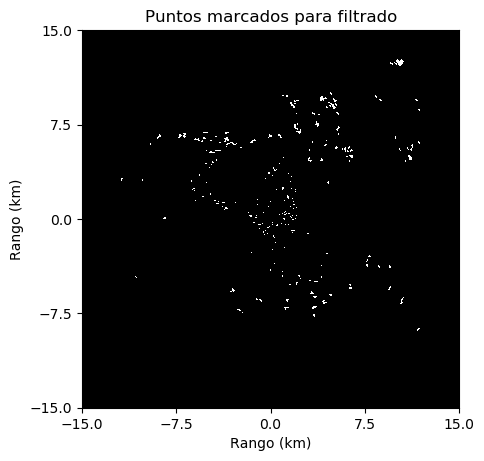

In [30]:
fig = util.ploteo(mark2, rmax=15, title='Puntos marcados para filtrado', cmap=plt.cm.gray)

Note que se ha logrado filtrar por conectividad sin tener que entrar a detalles como el ajuste de kernel, por lo que este procedimiento es mucho más sencillo de implementar por alguien que posee menos conocimientos del tema.

Sin embargo este procedimiento solo sirve para filtrar los elementos dispersos que no hallan sido marcados como background(en adelante 'filter'), por tanto no resuelve la selección de los agujeros presentes en la trama inicial('fill'). Para resolver ese detalle basta con calcular el procedimiento usando la imagen inversa del binarizado.

In [31]:
agujeros = util.filter_conectivity(application[2], connect=5, mode='fill')

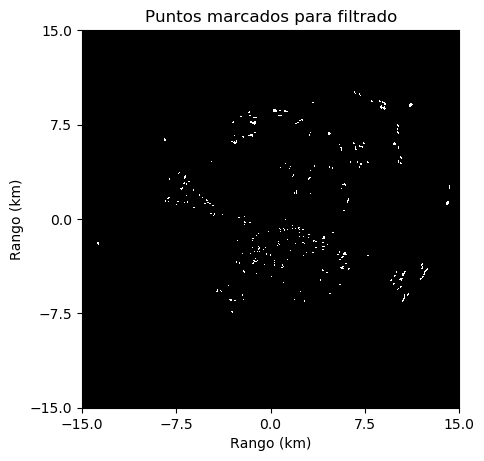

In [32]:
fig = util.ploteo(agujeros, rmax=15, title='Puntos marcados para filtrado', cmap=plt.cm.gray)

Dado que estas funciones son más intuitivas, el lector deberá tener mayor cuidado pues como cualquier procedimiento de corrección, no se encuentra excento de errores y siempre debe ser evaluado antes de ser aplicado.

En lineas generales se recomienda proceder con mayor cuidado para los datos de "fill" pues configurado puede conectar pequeñas zonas que no estaban en los datos originales. Es por ello que se recomienda usar primero el "fill" y luego la opción de "filter", además es mejor usar un número más pequeño para el llenado de los agujeros en la trama.

La gran ventaja de este metódo es que podemos filtrar no solo por tamaño relativo(número de píxeles), sino también por tamaño absoluto, si en lugar de pasar como argumento la imagen binarizada colocamos una imagen que contenga los valores del área real 
de cada píxel. En ese caso el procedimiento será más fuerte entre más cerca nos encontremos del radar.

### Marcado en base a operaciones morfológicas

Los procesos morfológicos constituyen una derivación de la teoría de conjuntos. Parten de las operaciones de unión e intersección y negación para realizar diversos procedimientos sobre la imagen. Si bien las anteriores representan las funciones básicas, se suele tomar como básicas las operaciones de dilatación, erosión, opening y closing, que nacen a partir de la imagen original y un elemento estructurante pequeño.

<img src="Morpho.png">
Emmanuelle Gouillart, Gaël Varoquaux (-) 2.6 Manipulación y procesamiento de imágenes usando Numpy y Scipy. Scipy lecture notes

En este caso usaremos los procedimientos de erosión + dilatación para eliminar elementos pequeños, así como el procedimiento de opening + closing

Como ya es usual trabajaremos con la imagen binaria.

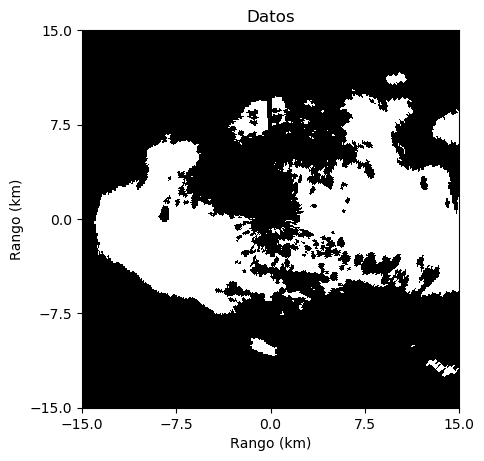

In [34]:
eroded_square = ndimage.binary_erosion(binarydata[2])
fig = util.ploteo(eroded_square, rmax=15, cmap=plt.cm.gray)

El proceso de erosión reduce los bordes y los elementos pequeños, por ello la imagen que vemos es mucho más "limpia" pero al mismo tiempo aumenta el tamaño de los agujeros. El borde de la imagen tambien se elimina(línea central superior).

A continuación realizamos el "proceso inverso", este término esta entre comillas porque obviamente no se trata de un proceso que devuelve a los valores originales. 

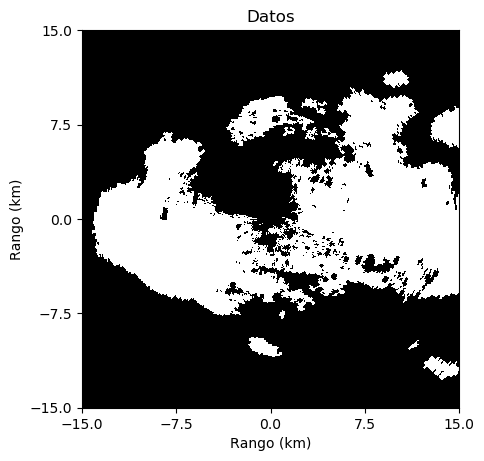

In [37]:
reconstruction = ndimage.binary_propagation(eroded_square, mask=binarydata[2])
fig = util.ploteo(reconstruction, rmax=15, cmap=plt.cm.gray)

Por último vemos los resultados del marcado a través del cluttermap.

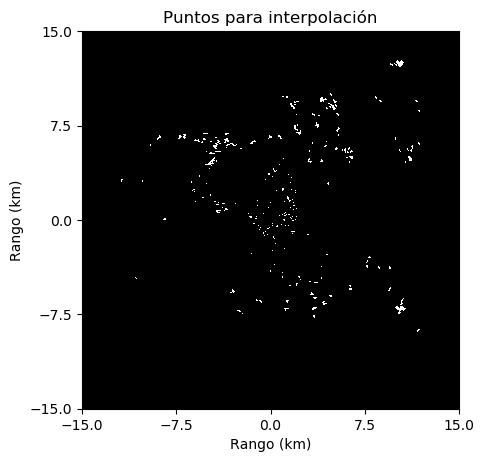

In [41]:
erode_and_propagation = ~reconstruction * binarydata[2]
fig = util.ploteo(erode_and_propagation, rmax=15, title='Puntos para interpolación', cmap=plt.cm.gray)

También se puede hacer lo mismo pero con la imagen inversa para eliminar los agujeros en la trama original.

Para finalizar veremos el proceso de opening + closing. Y no, no tiene que ver los animes. Dado que esta operación puede ser más difusa, veremos nuevamente la imagen binarizada.

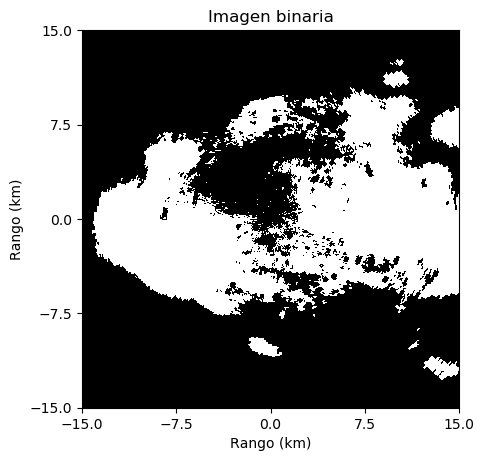

In [47]:
fig = util.ploteo(binarydata[2], rmax=15, title='Imagen binaria', cmap=plt.cm.gray)

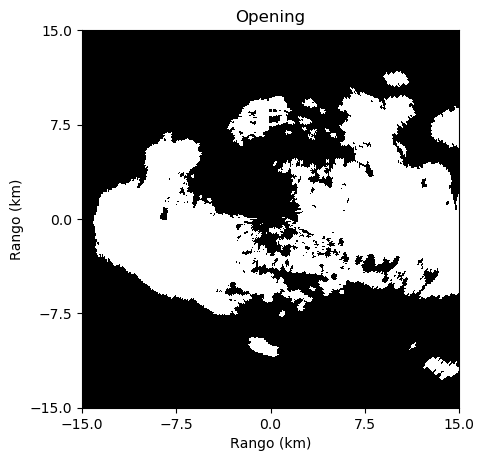

In [48]:
open_img = ndimage.binary_opening(binarydata[2])
fig = util.ploteo(open_img, rmax=15, title='Opening', cmap=plt.cm.gray)

Note como los pequeños puntos dispersos se han eliminado. También se han abierto los agujeros de la trama inicial.

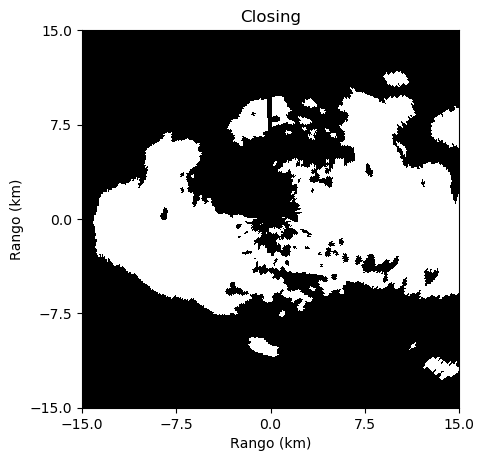

In [51]:
close_img = ndimage.binary_closing(open_img)
fig = util.ploteo(close_img, rmax=15, title='Closing', cmap=plt.cm.gray)

Nuevamente note que los bordes han sido desmarcados, esto ocurre porque la vecindad no se puede aplicar en los bordes propiamente, lo usual es programar algún comportamiento en los bordes, y el prederminado es el que ofrece estos resultados.

In [54]:
opening_and_ending = close_img.astype(bool) * ~binarydata[2].astype(bool)

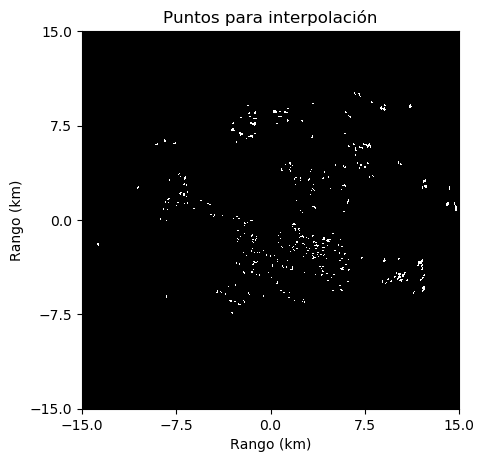

In [55]:
fig = util.ploteo(opening_and_ending, rmax=15, title='Puntos para interpolación', cmap=plt.cm.gray)

Una recomendación antes de acabar, si se ha estado atento en algunas partes ha aparecido el comando **`.astype(bool)`**, esto se hace para garantizar que la multiplicación de matrices se lleve a cabo de manera binaria, es decir en función de valores `True` or `False`. Si se omite puede traer problemas de inconsistencia en el resultado final. 

Me repito otra vez para afirmar que de la misma forma que hemos usado este proceso para eliminar pequeños elementos, esto se puede hacer a la inversa como ya se ha comentado previamente para cerrar agujeros. 

El lector observará que estos procesos morfológicos no han necesitado incluir ningún parámetro adicional como en los otros métodos. Esto no es cierto, en realidad, como se comentó en la introducción de este apartado, se usan elementos estructurantes para estos procesos. Solo sucede que estamos usando el predeterminado, que corresponde con la vecindad-8. Pueden probarse diversos elementos estructurantes dependiendo de que tamaños se deseen filtrar. Sin embargo, máscaras grandes degradarán la calidad original de la trama.

En el siguiente cuaderno veremos ... espera, ya me cansé de hacer cuadernos. Ahora te toca a ti ...

<img src="Sigues.jpg">

Bueno, no es la imagen más épica pero bueh...